### Preliminaries

In [39]:
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['Geodesic_tanbeta_ramp_fast_eta1p0']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])
    
from gmplib.utils import numify, get_pkg_path, export_results
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

import gme, sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, trigsimp, expand, factor, powsimp, \
    Eq, solve, solveset, sqrt, diff, Matrix, det, tan, cos, sin, sec, csc, \
    Abs, Rational, pi, re, im, atan, atan2, numer, denom, \
    lambdify, log, collect, cancel, integrate, Integral, \
    nroots, poly, lambdify, Array, derive_by_array, Indexed
from gme.symbols import *
from gme.plot import TimeDependent
from scipy.integrate import solve_ivp

from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

pr_path = get_pkg_path(gme)
pr_path, pr_filenames

('/Users/colinstark/Projects/GME/Parameters',
 ['Geodesic_tanbeta_ramp_fast_eta1p0'])

In [40]:
parameters_dict,_ = import_parameters([pr_path], ['defaults', *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'GeodesicSolutions',
    'short_name': 'gdsc',
    'subtitle': '',
    'title': 'Geodesic solution: ramp, eta=1, tan(beta) xi model',
    'verbose': True,
    'very_verbose': False}
{   'beta_type': 'tan',
    'chi': 30,
    'do_geodesic': False,
    'eta': 1,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    't_xiv0_list': None,
    'varphi_0': 10,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'g_custom_t_fn': 't-(t*(alpha)/0.4)',
    'h_custom_t_fn': 't-(t*(alpha)/0.4)',
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'Radau', 'geodesic': 'LSODA'},
    'n_rays': 50,
    'n_t': 301,
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.008,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 300,
    'spline

# Summary

This notebook solves for...

# Basics

Generate the GME equation set using Sympy, after specifying in the erosion model the gradient exponent $\eta$, the process transition model ("ramp" or "rampflat"), and the shape of the initial profile ("concave" or "convex"; not used here).

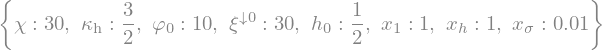

In [3]:
sub = {x_1: pr.model.x_1, 
       chi: pr.model.chi, 
       varphi_0: pr.model.varphi_0,
       xiv_0: pr.model.xiv_0,
       kappa_h: pr.model.kappa_h,
       h_0: pr.model.h_0,
       x_sigma: pr.model.x_sigma,
       x_h: pr.model.x_h}
sub

In [4]:
gmeq = gme.equations.Equations( eta=pr.model.eta, 
                                beta_type=pr.model.beta_type, varphi_type=pr.model.varphi_type, 
                                ibc_type=pr.model.ibc_type,
                                do_geodesic=True, parameters=sub )

Specify model parameters, such as the rate of vertical motion at the boundary $\xi^{\downarrow_{0}}$ and the position of the ramp-flat transition $x_h$.

# Christoffel symbols

Construct reasonably fast functions to generate Christoffel symbols of the second kind, which are needed to compute the geodesic equations.

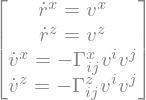

In [5]:
vdotx, vdotz = symbols('\\dot{v}^x \\dot{v}^z',  real=True)
vi, vj = symbols('v^i v^j', real=True)
Christoffel_x_ij = symbols('\\Gamma^x_{ij}', real=True)
Christoffel_z_ij = symbols('\\Gamma^z_{ij}', real=True)
Christoffel_x = symbols('\\Gamma^x', real=True)
Christoffel_z = symbols('\\Gamma^z', real=True)

geodesic_eqns_succinct = Matrix([
    Eq(rdotx_true, rdotx),
    Eq(rdotz_true, rdotz),
    Eq(vdotx, -Christoffel_x_ij * vi*vj),
    Eq(vdotz, -Christoffel_z_ij * vi*vj)
])
geodesic_eqns_succinct

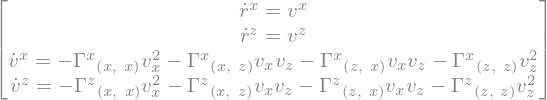

In [6]:
geodesic_eqns_explicit = Matrix([
    Eq(rdotx_true, rdotx),
    Eq(rdotz_true, rdotz),
    Eq(vdotx, (-Indexed(Christoffel_x,(x,x))*Indexed(rdot,x)*Indexed(rdot,x)
               -Indexed(Christoffel_x,(x,z))*Indexed(rdot,x)*Indexed(rdot,z))
               +
              (-Indexed(Christoffel_x,(z,x))*Indexed(rdot,z)*Indexed(rdot,x)
               -Indexed(Christoffel_x,(z,z))*Indexed(rdot,z)*Indexed(rdot,z)) ),
    Eq(vdotz, (-Indexed(Christoffel_z,(x,x))*Indexed(rdot,x)*Indexed(rdot,x)
               -Indexed(Christoffel_z,(x,z))*Indexed(rdot,x)*Indexed(rdot,z))
               +
              (-Indexed(Christoffel_z,(z,x))*Indexed(rdot,z)*Indexed(rdot,x)
               -Indexed(Christoffel_z,(z,z))*Indexed(rdot,z)*Indexed(rdot,z)) ) 
])
geodesic_eqns_explicit

# ODE integration

Integrate...

In [7]:
drvdt_eqn_matrix = Matrix(([(eq_.rhs) for eq_ in gmeq.geodesic_eqns ])) #factor
drvdt_raw_lambda = lambdify( [rx, rdotx, rdotz], drvdt_eqn_matrix )
drvdt_lambda = lambda t_, rv_: np.ndarray.flatten( drvdt_raw_lambda(rv_[0],rv_[2],rv_[3]) )

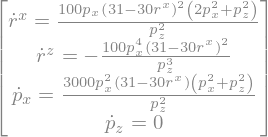

In [8]:
gmeq.hamiltons_eqns.subs(sub)

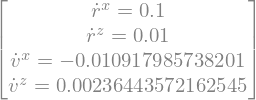

In [9]:
dummy = {ta:0.5, rx:0.5,rdotx:0.1,rdotz:0.01}
gmeq.geodesic_eqns.subs(dummy).subs(sub).applyfunc(sy.N)

Create an instance of the ODE solution object.

In [10]:
pr.solve.h_custom_t_fn
if pr.solve.h_custom_t_fn is not None:
    h_custom_t_fn = lambda t, alpha: eval(pr.solve.h_custom_t_fn)
else:
    h_custom_t_fn = None
if pr.solve.g_custom_t_fn is not None:
    g_custom_t_fn = lambda t, alpha: eval(pr.solve.g_custom_t_fn)
else:
    g_custom_t_fn = None

In [11]:
sy.N(gmeq.px_initial_eqn.subs(sub).subs({x:0})), sy.N(gmeq.pz_initial_eqn.subs(sub).subs({x:0}))

In [12]:
pr.solve.n_rays = 10
pr.plot.ray_subsetting = 3

In [13]:
choice = 'Hamilton'
gmes_hmltn = gme.ode.InitialCornerSolution( gmeq, parameters=sub, 
                                            choice=choice,
                                            method=pr.solve.method[choice],
                                            t_end=pr.solve.t_end, 
                                            n_rays=pr.solve.n_rays,
                                            customize_t_fn=h_custom_t_fn,
                                            verbose=True )

Solve Hamilton's ODEs using Radau method of integration


In [14]:
choice = 'geodesic'
gmes_gdsc = gme.ode.InitialCornerSolution( gmeq, parameters=sub, 
                                           choice=choice, 
                                           method=pr.solve.method[choice],
                                           t_end=pr.solve.t_end, 
                                           n_rays=pr.solve.n_rays,
                                           customize_t_fn=g_custom_t_fn, 
                                           do_dense=pr.solve.do_dense,
                                           verbose=True )

Solve geodesic ODEs using LSODA method of integration


### Misc

In [15]:
dXdt_lambda = gmes_hmltn.make_model()
dXdt_lambda

<function gme.ode.BaseSolution.make_model.<locals>.<lambda>(t_, rp_)>

In [16]:
beta_ = gmes_hmltn.beta_surface_corner
beta_

In [17]:
ic_rp_ = gmes_hmltn.initial_conditions(beta_)
ic_rp_[0:4]

In [18]:
pr.solve.t_end 
t_array = np.linspace(0, pr.solve.t_end, pr.solve.n_t)
soln_ivp = solve_ivp( dXdt_lambda, 
                      [t_array[0],t_array[-1]], 
                      ic_rp_,
                      method='Radau',
                      t_eval=t_array,
                      dense_output=True,
                      vectorized=False )
hamiltonian_rp_soln_ = soln_ivp.y

In [19]:
ic_rrdot_ = gmes_gdsc.initial_conditions(beta_)
ic_rrdot_[0:4]

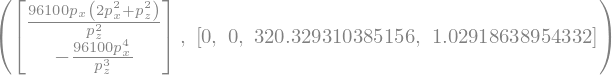

In [20]:
rdot_ = Matrix([
    gmeq.hamiltons_eqns[0].rhs.subs(sub),
    gmeq.hamiltons_eqns[1].rhs.subs(sub)
])
ic_rdot_ = rdot_.subs({rx:ic_rp_[0],px:ic_rp_[2],pz:ic_rp_[3]})
ic_rrdot_ = [*ic_rp_[0:2],*ic_rdot_]
rdot_.subs({rx:0}), ic_rrdot_

In [21]:
dXdt_lambda = gmes_gdsc.make_model()
dXdt_lambda

<function gme.ode.BaseSolution.make_model.<locals>.<lambda>(t_, rv_)>

In [22]:
pr.solve.method['geodesic']

'LSODA'

In [23]:
pr.solve.t_end 
t_array = np.linspace(0, pr.solve.t_end, pr.solve.n_t)
soln_ivp = solve_ivp( dXdt_lambda, 
                      [t_array[0],t_array[-1]], 
                      ic_rrdot_,
                      method='Radau', #pr.solve.method['geodesic'],
                      t_eval=t_array,
                      dense_output=False,
                      vectorized=False )
geodesic_rv_soln_ = soln_ivp.y
# geodesic_rv_soln_

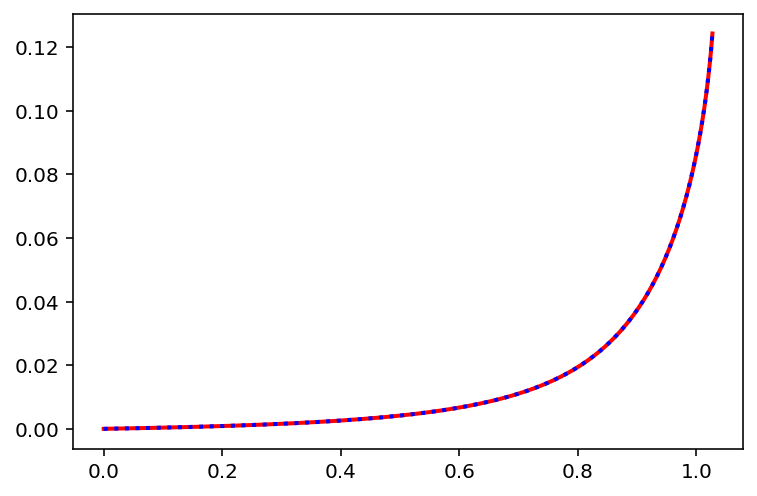

In [24]:
import matplotlib.pyplot as plt
plt.plot(geodesic_rv_soln_[0],geodesic_rv_soln_[1], '-', lw=2, color='r')
plt.plot(hamiltonian_rp_soln_[0],hamiltonian_rp_soln_[1], ':', lw=2, color='b')

## Specify the set of ODEs and integrate them.

In [26]:
pr.solve.method['geodesic'] = 'RK45'
gmes_gdsc.solve(report_pc_step=0.1)
print('Message: {}\nSuccess? {}\nStatus: {}\nt_final: {}\nrx_final: {}'
      .format(gmes_gdsc.solns[0].message, gmes_gdsc.solns[0].success,
              gmes_gdsc.solns[0].status,  gmes_gdsc.solns[0].t[-1], 
              gmes_gdsc.solns[0].y[0][-1]) )

Solving geodesic equations
0% 11% 22% 33% 44% 56% 67% 78% 89% 100% 
Message: The solver successfully reached the end of the integration interval.
Success? True
Status: 0
t_final: 0.0078408
rx_final: 1.0240575046902745


In [27]:
gmes_gdsc.postprocessing()

In [28]:
gmes_gdsc.resolve_isochrones( t_isochrone_max=pr.resolve.t_isochrone_max, 
                              tolerance=pr.resolve.tolerance, 
                              n_isochrones=pr.resolve.n_isochrones,
                              do_eliminate_caustics=pr.resolve.do_eliminate_caustics )

In [29]:
gmes_hmltn.solve()
print('Message: {}\nSuccess? {}\nStatus: {}\nt_final: {}\nrx_final: {}'
      .format(gmes_hmltn.solns[0].message, gmes_hmltn.solns[0].success,
              gmes_hmltn.solns[0].status, gmes_hmltn.solns[0].t[-1], 
              gmes_hmltn.solns[0].y[0][-1]) )

Solving Hamilton's equations
0% 11% 22% 33% 44% 56% 67% 78% 89% 100% 
Message: The solver successfully reached the end of the integration interval.
Success? True
Status: 0
t_final: 0.008
rx_final: 1.0272595878734552


In [30]:
gmes_hmltn.postprocessing()

Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses  $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [31]:
gmes_hmltn.resolve_isochrones( t_isochrone_max=pr.resolve.t_isochrone_max, 
                               tolerance=pr.resolve.tolerance, 
                               n_isochrones=pr.resolve.n_isochrones,
                               do_eliminate_caustics=pr.resolve.do_eliminate_caustics )

Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses  $\{\mathbf{\widetilde{p}}\}$, into various arrays.

# Plots

Graph a selection of staggered ray solutions (colorized lines with arrows) along with the time-invariant solution solved for in two ways (gathering of staggered ray termini or integration of gradients along a ray).

In [32]:
gr = TimeDependent()

In [33]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_{pr.model.beta_type}beta_eta{sy.N(gmeq.eta):1.1f}_xiv{sy.N(gmes_gdsc.parameters[xiv_0]):1.0f}'
suffix = (suffix if pr.model.varphi_type=='ramp' \
                else suffix+'_xh{:1.1f}'.format(gmes_gdsc.parameters[x_h])).replace('.','p')

job_name = prefix+suffix
job_name

'gdsc_tanbeta_ramp_tanbeta_eta1p0_xiv30'

In [34]:
# pr.plot.dimz_limits = [-0.5,0.15]

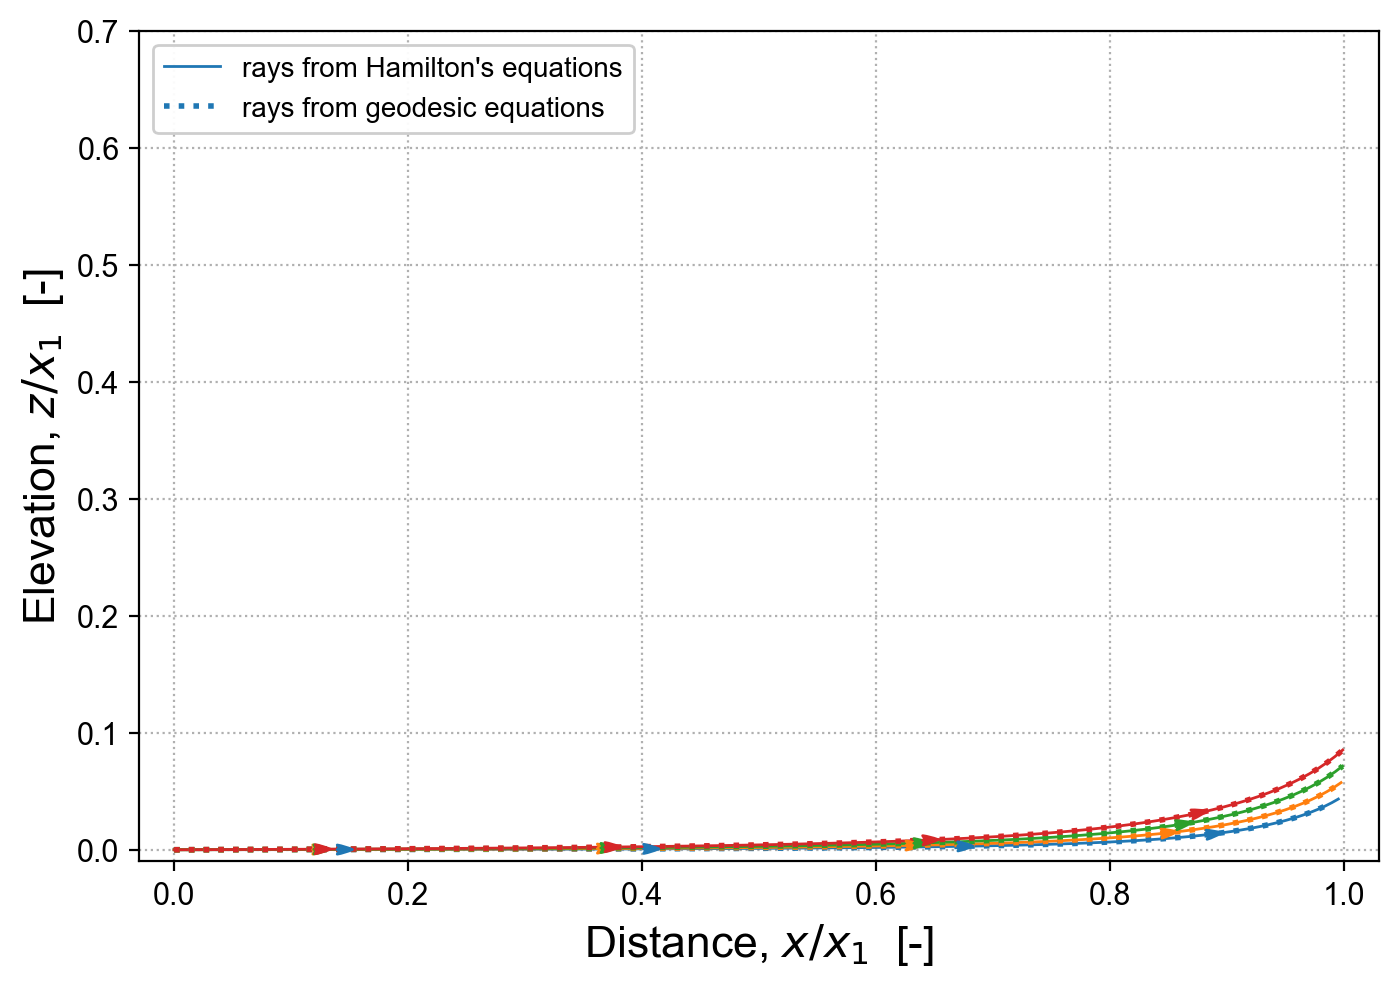

In [35]:
fig = \
gr.profile_isochrones( gmes_hmltn, gmeq, sub, job_name+'_h_rays', fig_size=(8,8), 
                       do_zero_isochrone=False, do_rays=True, 
                       ray_label='rays from Hamilton\'s equations', ray_lw=1, ray_ls='-', 
                       ray_subsetting=pr.plot.ray_subsetting,
                       do_annotate_rays=True, n_arrows=5, arrow_sf=0.5, do_isochrones=False,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits 
                     )

gr.profile_isochrones( gmes_gdsc, gmeq, sub, job_name+'_h_rays', fig_size=(8,8), 
                       do_zero_isochrone=False, do_rays=True, do_overlay=True, fig=fig,
                       ray_label='rays from geodesic equations', 
                       ray_lw=2, ray_ls=':', ray_subsetting=pr.plot.ray_subsetting,
                       do_annotate_rays=False, do_isochrones=False,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits 
                     );

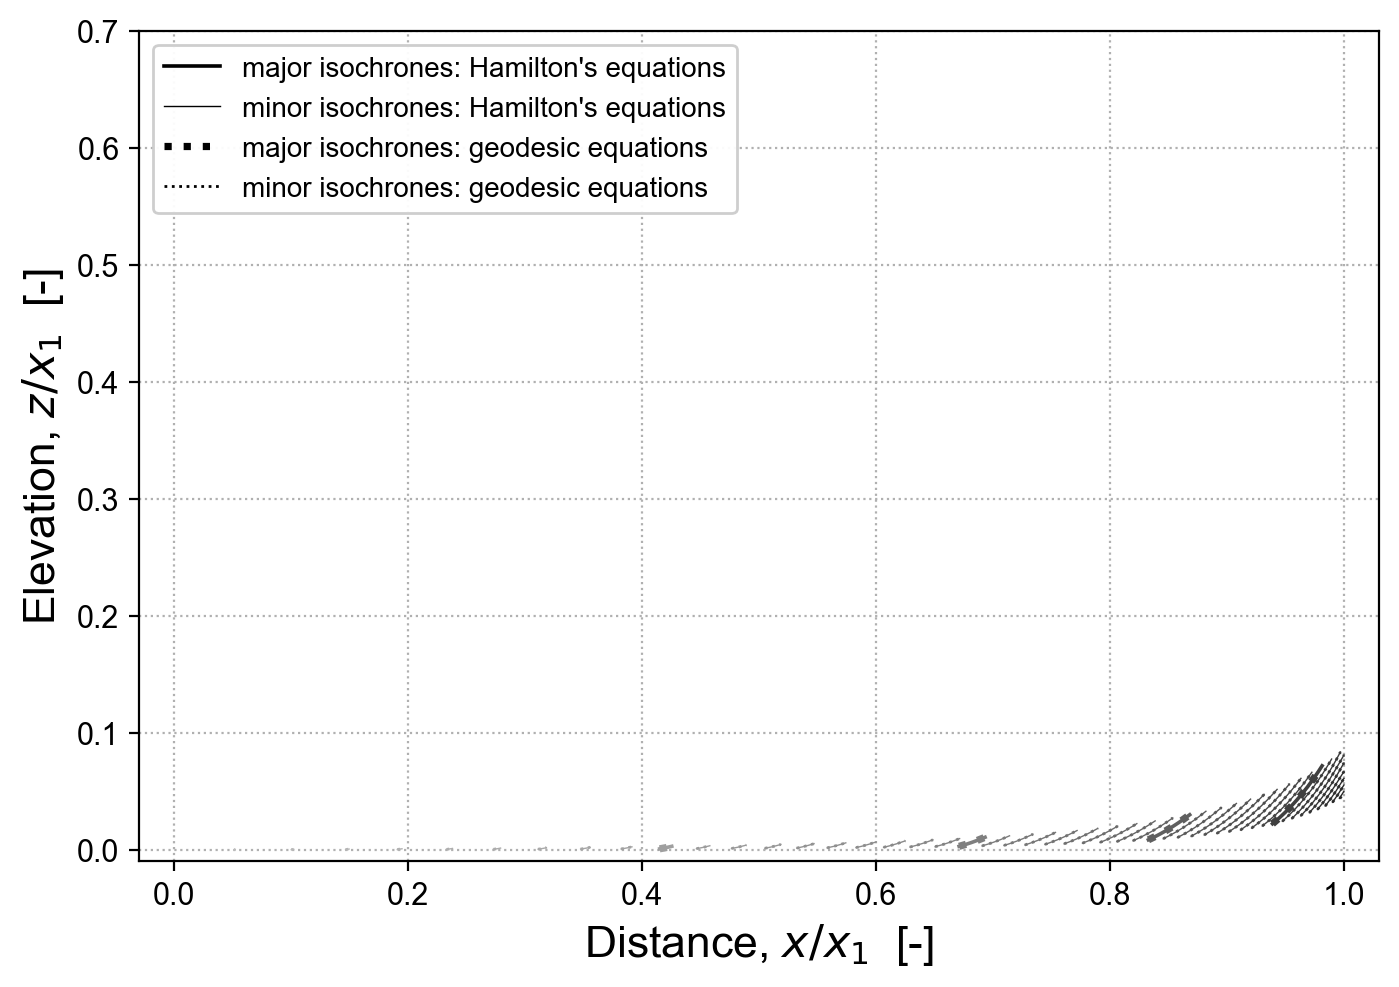

In [36]:
fig = gr.profile_isochrones( gmes_hmltn, gmeq, sub, job_name+'_h_isochrones', fig_size=(8,8), 
                             do_zero_isochrone=False, do_rays=False,
                             ray_subsetting=pr.plot.ray_subsetting,
                             do_isochrones=True, do_annotate_cusps=False,
                             isochrone_lw=1, isochrone_ls='-', 
                             isochrone_label='isochrones: Hamilton\'s equations',
                             isochrone_subsetting=pr.plot.isochrone_subsetting,
                             x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits )

gr.profile_isochrones( gmes_gdsc, gmeq, sub, job_name+'_h_isochrones', fig_size=(8,8), 
                       do_zero_isochrone=False, do_rays=False, do_overlay=True, fig=fig,
                       ray_subsetting=pr.plot.ray_subsetting,
                       do_isochrones=True, do_annotate_cusps=False,
                       isochrone_lw=2, isochrone_ls=':', 
                       isochrone_label='isochrones: geodesic equations',
                       isochrone_subsetting=pr.plot.isochrone_subsetting,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits );

# Save

In [37]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/GeodesicSolutions"
Exported "gdsc_tanbeta_ramp_tanbeta_eta1p0_xiv30_h_rays.png"
Exported "gdsc_tanbeta_ramp_tanbeta_eta1p0_xiv30_h_isochrones.png"
